# Deadly Police Encounters - Data Acquisition and EDA

Amanda Cheney  
Metis Project 3  
Part 1 of 2  
October 28, 2020

**Objective**

Build a classification model that can identify where deadly encounters are likely to happen based on socio-economic characteristics of the communities in which they occur.

**Data Sources**

The Mapping Police Violence project which has data on all deadly police encounters nationwide that including information about the precise location of the killing as well as information about the victim’s race.

American Community Survey Data from the US Census Bureau which has data on key socio-economic indicators like education, unemployment, rates of health insurance coverage, use of food stamps, computer ownership and access to the internet – nearly all of which the ACS offers data on by racial/ ethnic categories.

Note: I have retained the original ACS codes for all of my features throughout this notebook until the section on feature importance where I provide descriptions of the top 10 most important features. For interpreation of all other feature variables, please consult the Project 3 Codebook file.


### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import requests

### Load Mapping Police Dataset

In [2]:
mpv = pd.read_excel('/Users/AmandaCheney/github/police_violence_v1/MPV_data/MPVDatasetDownload.xlsx')

In [3]:
mpv.columns = mpv.columns.str.strip()

In [4]:
mpv.shape

(8485, 31)

In [5]:
mpv.columns

Index(['Victim's name', 'Victim's age', 'Victim's gender', 'Victim's race',
       'URL of image of victim', 'Date of Incident (month/day/year)',
       'Street Address of Incident', 'City', 'State', 'Zipcode', 'County',
       'Agency responsible for death', 'ORI Agency Identifier (if available)',
       'Cause of death',
       'A brief description of the circumstances surrounding the death',
       'Official disposition of death (justified or other)',
       'Criminal Charges?',
       'Link to news article or photo of official document',
       'Symptoms of mental illness?', 'Unarmed/Did Not Have an Actual Weapon',
       'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)',
       'Alleged Threat Level (Source: WaPo)', 'Fleeing (Source: WaPo)',
       'Body Camera (Source: WaPo)', 'WaPo ID (If included in WaPo database)',
       'Off-Duty Killing?',
       'Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-co

#### Examining the racial composition of the database

In [6]:
mpv["Victim's race"].unique()

array(['White', 'Hispanic', 'Unknown race', 'Black', 'Asian',
       'Native American', 'Pacific Islander'], dtype=object)

In [7]:
poc_mask1 = mpv["Victim's race"]!='White'
poc_mask2 = mpv["Victim's race"]!='Unknown race'
poc_mask = poc_mask1 & poc_mask2
poc = mpv[poc_mask]
poc.shape

(3896, 31)

3896 of the victims in deadly police encounters since 2013 have been people of color.

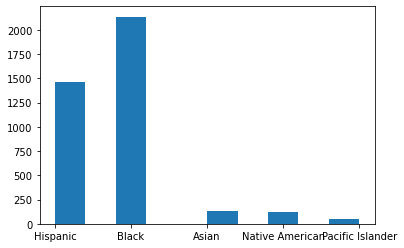

In [8]:
plt.hist(poc["Victim's race"]);

In [9]:
racial_breakdown = mpv["Victim's race"].value_counts()
racial_breakdown

White               3732
Black               2136
Hispanic            1464
Unknown race         857
Asian                131
Native American      119
Pacific Islander      46
Name: Victim's race, dtype: int64

In [10]:
# for victim's whose race is known, tallying the percent of victims who are people of color 
(racial_breakdown[1]+racial_breakdown[2]+racial_breakdown[4]+racial_breakdown[5]+racial_breakdown[6])/(sum(racial_breakdown)-racial_breakdown[3])

0.5107498689040377

This intial EDA shows that 8,485 people have been killed by law enforcement agents in the US since 2013. 51% of whom are people of color -- even though they make up less than 40% of the overall population. Therefore I want to focus specifically on the problem of people of color who are killed in deadly police encounters. 

In [11]:
mpv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8485 entries, 0 to 8484
Data columns (total 31 columns):
 #   Column                                                                                                                                                                      Non-Null Count  Dtype         
---  ------                                                                                                                                                                      --------------  -----         
 0   Victim's name                                                                                                                                                               8485 non-null   object        
 1   Victim's age                                                                                                                                                                8474 non-null   object        
 2   Victim's gender                                         

Since the Mapping Police Violence data has zip code information for its entire dataset of all deadly encounters – my observations are individual zip codes. So for all zip codes in entire the United States, my model will eventually seek to explain which zip codes have deadly encounters in which people of color are killed by police and which zip codes do not by comparing their socio-economic characteristics.

#### Create features to eventually measure for each zip code:  
- total number of deadly encounters `deadly_encounter`  
- total number of people of color killed `poc_killed`   
--------
Note that the values for each these featurs are the "true" counts which range from 0 to 10. After I merge with census data, all the zipcodes not included in `mpv_zipcode` will be assigned values of -1. My intention is to do a binary target variable, but I am preserving values to allow flexibility.

In [12]:
mpv_df = mpv.copy()

In [13]:
mpv_df['deadly_encounter'] = 1 # assign a value of 1 to each entry which represents an incident of a deadly encounter with police

In [14]:
mpv_df['poc'] = mpv_df["Victim's race"].apply(lambda x:1 if x!='White' and x!='Unknown race' else 0)

In [15]:
len(mpv_df['Zipcode'].unique()) # includes nan 

5328

In [16]:
deadlyGroup = mpv_df.groupby(['Zipcode'])['deadly_encounter'].sum().reset_index()
pocGroup = mpv_df.groupby(['Zipcode'])['poc'].sum().reset_index()

In [17]:
mpv_zipcode = deadlyGroup.merge(pocGroup, how='left', on="Zipcode")

In [18]:
mpv_zipcode.shape #nan no longer present 

(5327, 3)

5,327 unique zipcodes have had deadly police encounters since 2013. 

Now to clean up the zipcode variable.

In [19]:
# MPV zipcodes are imported as floats and accidentally drop leading zeros (tho they are present in the csv they get 
# lost on import so I need to add those back and convert as type str to enable merge w/ census data (and protect 
# leading zero)
mpv_zipcode['Zipcode']=mpv_zipcode['Zipcode'].astype(int)
mpv_zipcode['Zipcode']=mpv_zipcode['Zipcode'].astype(str)
mpv_zipcode['Zipcode'] = mpv_zipcode['Zipcode'].apply(lambda x: '0'+x if len(x)<5 else x)

# rename zipcode column 'zip code tabulation area' to enable merge with census data 
mpv_zipcode.rename(columns={'Zipcode':'zip code tabulation area'}, inplace=True)

## Acquire ACS Data from the Census API

I acquire ACS data from two different sources (1) the 2018 Subject Tables and (2) the 2018 Data Profiles. Rather than grab all of the variables I am interested in in one go from each of these API's, I have chosen to break up my data acquisition by the different sets of socio-economic indicators I'm interested in. I also pickle the individual DataFrames just to make sure I don't lose the data.

In [20]:
def database_maker(year,version,geocode,variables):
    api = f"https://api.census.gov/data/{year}/acs/acs5/{version}?get={variables}&for={geocode}:*"
    return pd.DataFrame(requests.get(api).json()[1:], columns=requests.get(api).json()[0])

**Population** 

`S0101_C01_001E` Estimate!!Total!!Total population

In [21]:
pop_var = 'S0101_C01_001E'
total_pop = database_maker('2018', 'subject','zip%20code%20tabulation%20area', pop_var)
total_pop = total_pop[['zip code tabulation area', 'S0101_C01_001E']] # re-order cols to use total_pop as base of merging dataframes

In [22]:
with open('total_pop.pickle', 'wb') as to_write:
    pickle.dump(total_pop, to_write)

**Race** 

`DP05_0078PE`	Percent Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Black or African American alone  
`DP05_0071PE`	Percent Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)  
`DP05_0077PE`	Percent Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!White alone  

In [23]:
race_vars='DP05_0078PE,DP05_0071PE,DP05_0077PE'
race = database_maker('2018', 'profile','zip%20code%20tabulation%20area',race_vars)

In [24]:
with open('race.pickle', 'wb') as to_write:
    pickle.dump(race, to_write)

**Median Income**

`S1903_C03_001E` Estimate!!Median income (dollars)!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households  
`S1903_C03_003E` Estimate!!Median income (dollars)!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!One race--!!Black or  African American  
`S1903_C03_009E` Estimate!!Median income (dollars)!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!Hispanic or Latino origin  (of any race)  
`S1903_C03_010E` Estimate!!Median income (dollars)!!HOUSEHOLD INCOME BY RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Households!!White alone, not Hispanic  or Latino

In [25]:
mi_var = 'S1903_C03_001E,S1903_C03_003E,S1903_C03_009E,S1903_C03_010E'
median_income = database_maker('2018', 'subject','zip%20code%20tabulation%20area', mi_var)
# median_income = database_maker('2018', 'subject','zip%20code%20tabulation%20area',
#                                'S1903_C03_001E,S1903_C03_003E,S1903_C03_009E,S1903_C03_010E')

In [26]:
with open('median_income.pickle', 'wb') as to_write:
    pickle.dump(median_income, to_write)

**Education**

`DP02_0066PE`	Percent Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher  
`DP02_0067PE`	Percent Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher  
Note - there is no breakdown by racial/ ethnic groups for these variables


In [27]:
hs_grad_var = 'DP02_0066PE,DP02_0067PE'
hs_grad = database_maker('2018', 'profile','zip%20code%20tabulation%20area', hs_grad_var)

In [28]:
with open('hs_grad.pickle', 'wb') as to_write:
    pickle.dump(hs_grad, to_write)

**Insurance** 

`S2701_C03_001E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population  
 `S2701_C03_017E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!RACE AND HISPANIC OR LATINO ORIGIN!!Black or African American alone  
`S2701_C03_023E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!RACE AND HISPANIC OR LATINO ORIGIN!!Hispanic or Latino (of any race)  
`S2701_C03_024E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!RACE AND HISPANIC OR LATINO ORIGIN!!White alone, not Hispanic or Latino 

`S2701_C05_001E`	Estimate!!Percent Uninsured!!Civilian noninstitutionalized population  
`S2701_C03_038E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!EDUCATIONAL ATTAINMENT!!Civilian noninstitutionalized population 26 years and over!!Less than high school graduate  
`S2701_C03_039E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!EDUCATIONAL ATTAINMENT!!Civilian noninstitutionalized population 26 years and over!!High school graduate (includes equivalency)  

`S2701_C03_044E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!EMPLOYMENT STATUS!!Civilian noninstitutionalized population 19 to 64 years!!In labor force!!Employed  
`S2701_C03_045E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!EMPLOYMENT STATUS!!Civilian noninstitutionalized population 19 to 64 years!!In labor force!!Unemployed  
`S2701_C03_046E`	Estimate!!Percent Insured!!Civilian noninstitutionalized population!!EMPLOYMENT STATUS!!Civilian noninstitutionalized population 19 to 64 years!!Not in labor force  

In [29]:
insurance_var = 'S2701_C03_001E,S2701_C03_017E,S2701_C03_023E,S2701_C03_024E,S2701_C05_001E,S2701_C03_038E,S2701_C03_039E,S2701_C03_044E,S2701_C03_045E,S2701_C03_046E'
insurance = database_maker('2018', 'subject','zip%20code%20tabulation%20area', insurance_var)

In [30]:
with open('insurance.pickle', 'wb') as to_write:
    pickle.dump(insurance, to_write)

**Poverty**

`S2201_C02_021E`	Estimate!!Percent!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!Below poverty level  
`S2201_C02_022E`	Estimate!!Percent!!Households!!POVERTY STATUS IN THE PAST 12 MONTHS!!At or above poverty level  

In [31]:
pov_var = 'S2201_C02_021E,S2201_C02_022E'
poverty = database_maker('2018', 'subject','zip%20code%20tabulation%20area', pov_var)

In [32]:
with open('poverty.pickle', 'wb') as to_write:
    pickle.dump(poverty, to_write)

**SNAP/ Food stamps**

`S2201_C04_001E`	Estimate!!Percent households receiving food stamps/SNAP!!Households  
`S2201_C04_009E`	Estimate!!Percent households receiving food stamps/SNAP!!Households!!With children under 18 years  
`S2201_C04_013E`	Estimate!!Percent households receiving food stamps/SNAP!!Households!!With children under 18 years!!Other family!!Female householder, no husband present  

`S2201_C04_026E`	Estimate!!Percent households receiving food stamps/SNAP!!Households!!RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Black or African American alone  
`S2201_C04_032E`	Estimate!!Percent households receiving food stamps/SNAP!!Households!!RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!Hispanic or Latino origin (of any race)  
`S2201_C04_033E`	Estimate!!Percent households receiving food stamps/SNAP!!Households!!RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!White alone, not Hispanic or Latino  

In [33]:
snap_var = 'S2201_C04_001E,S2201_C04_009E,S2201_C04_013E,S2201_C04_026E,S2201_C04_032E,S2201_C04_033E'
snap = database_maker('2018', 'subject','zip%20code%20tabulation%20area', snap_var)

In [34]:
with open('snap.pickle', 'wb') as to_write:
    pickle.dump(snap, to_write)

**Unemployment**

`S2201_C02_036E`	Estimate!!Percent!!WORK STATUS!!Families!!No workers in past 12 months  
`S2301_C04_001E`	Estimate!!Unemployment rate!!Population 16 years and over  
`S2301_C04_006E`	Estimate!!Unemployment rate!!Population 16 years and over!!AGE!!35 to 44 years  
`S2301_C04_020E`	Estimate!!Unemployment rate!!Population 16 years and over!!RACE AND HISPANIC OR LATINO ORIGIN!!White alone, not Hispanic or Latino  
`S2301_C04_013E`	Estimate!!Unemployment rate!!Population 16 years and over!!RACE AND HISPANIC OR LATINO ORIGIN!!Black or African American alone  
`S2301_C04_019E`	Estimate!!Unemployment rate!!Population 16 years and over!!RACE AND HISPANIC OR LATINO ORIGIN!!Hispanic or Latino origin (of any race)  

`S2301_C04_021E`	Estimate!!Unemployment rate!!Population 20 to 64 years  
`S2301_C04_022E`	Estimate!!Unemployment rate!!Population 20 to 64 years!!SEX!!Male  
`S2301_C04_023E`	Estimate!!Unemployment rate!!Population 20 to 64 years!!SEX!!Female  



`S2301_C04_032E`	Estimate!!Unemployment rate!!EDUCATIONAL ATTAINMENT!!Population 25 to 64 years!!Less than high school graduate
`S2301_C04_033E`	Estimate!!Unemployment rate!!EDUCATIONAL ATTAINMENT!!Population 25 to 64 years!!High school graduate (includes equivalency)


In [35]:
unemployment_var = 'S2201_C02_036E,S2301_C04_001E,S2301_C04_006E,S2301_C04_020E,S2301_C04_013E,S2301_C04_019E,S2301_C04_021E,S2301_C04_022E,S2301_C04_023E,S2301_C04_032E,S2301_C04_033E'
unemployment = database_maker('2018', 'subject','zip%20code%20tabulation%20area', unemployment_var)

In [36]:
with open('unemployment.pickle', 'wb') as to_write:
    pickle.dump(unemployment, to_write)

**Access to Technology**


`S2802_C05_001E`	Estimate!!With a computer!!Percent without an Internet Subscription!!Total population in households  
`S2802_C05_006E`	Estimate!!With a computer!!Percent without an Internet Subscription!!Total population in households!!RACE AND HISPANIC OR LATINO ORIGIN!!Black or African American alone  
`S2802_C05_012E`	Estimate!!With a computer!!Percent without an Internet Subscription!!Total population in households!!RACE AND HISPANIC OR LATINO ORIGIN!!Hispanic or Latino origin (of any race)  
`S2802_C05_013E`	Estimate!!With a computer!!Percent without an Internet Subscription!!Total population in households!!RACE AND HISPANIC OR LATINO ORIGIN!!White alone, not Hispanic or Latino  

`S2802_C07_001E`	Estimate!!Percent no computer in household!!Total population in households  
`S2802_C07_006E`	Estimate!!Percent no computer in household!!Total population in households!!RACE AND HISPANIC OR LATINO ORIGIN!!Black or African American alone  
`S2802_C07_012E`	Estimate!!Percent no computer in household!!Total population in households!!RACE AND HISPANIC OR LATINO ORIGIN!!Hispanic or Latino origin (of any race)  
`S2802_C07_013E`	Estimate!!Percent no computer in household!!Total population in households!!RACE AND HISPANIC OR LATINO ORIGIN!!White alone, not Hispanic or Latino  


In [37]:
tech_var = 'S2802_C05_001E,S2802_C05_006E,S2802_C05_012E,S2802_C05_013E,S2802_C07_001E,S2802_C07_006E,S2802_C07_012E,S2802_C07_013E'
tech = database_maker('2018', 'subject','zip%20code%20tabulation%20area', tech_var)

In [38]:
with open('tech.pickle', 'wb') as to_write:
    pickle.dump(tech, to_write)

## Build Data Frame 

In [39]:
df = total_pop.merge(median_income, how='outer', on='zip code tabulation area')

In [40]:
df.shape

(33120, 6)

In [41]:
df = df.merge(race, how='outer', on='zip code tabulation area')

In [42]:
df = df.merge(hs_grad, how='outer', on='zip code tabulation area')

In [43]:
df = df.merge(insurance, how='outer', on='zip code tabulation area')

In [44]:
df = df.merge(poverty, how='outer', on='zip code tabulation area')

In [45]:
df = df.merge(snap, how='outer', on='zip code tabulation area')

In [46]:
df = df.merge(unemployment, how='outer', on='zip code tabulation area')

In [47]:
df = df.merge(tech, how='outer', on='zip code tabulation area')

In [48]:
df = df.merge(mpv_zipcode, how='outer', on='zip code tabulation area')

In [49]:
df.shape

(33139, 50)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33139 entries, 0 to 33138
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   zip code tabulation area  33139 non-null  object 
 1   S0101_C01_001E            33120 non-null  object 
 2   S1903_C03_001E            33085 non-null  object 
 3   S1903_C03_003E            33085 non-null  object 
 4   S1903_C03_009E            33085 non-null  object 
 5   S1903_C03_010E            33085 non-null  object 
 6   DP05_0078PE               33120 non-null  object 
 7   DP05_0071PE               33120 non-null  object 
 8   DP05_0077PE               33120 non-null  object 
 9   DP02_0066PE               32989 non-null  object 
 10  DP02_0067PE               32989 non-null  object 
 11  S2701_C03_001E            33120 non-null  object 
 12  S2701_C03_017E            33120 non-null  object 
 13  S2701_C03_023E            33120 non-null  object 
 14  S2701_

Most of the ACS Census data is appearing as objects/strings so let's convert them to floats. 

In [51]:
df.iloc[:,1:50] = df.iloc[:,1:50].astype(float)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33139 entries, 0 to 33138
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   zip code tabulation area  33139 non-null  object 
 1   S0101_C01_001E            33120 non-null  float64
 2   S1903_C03_001E            33085 non-null  float64
 3   S1903_C03_003E            33085 non-null  float64
 4   S1903_C03_009E            33085 non-null  float64
 5   S1903_C03_010E            33085 non-null  float64
 6   DP05_0078PE               33120 non-null  float64
 7   DP05_0071PE               33120 non-null  float64
 8   DP05_0077PE               33120 non-null  float64
 9   DP02_0066PE               32989 non-null  float64
 10  DP02_0067PE               32989 non-null  float64
 11  S2701_C03_001E            33120 non-null  float64
 12  S2701_C03_017E            33120 non-null  float64
 13  S2701_C03_023E            33120 non-null  float64
 14  S2701_

## Data Engineering 

#### Filling null values for all the deadly encounter features from the MPV dataset. 
Because only 5327 zipcodes have had deadly police encounters, we need to assign a value to all the other zipcodes in `df`.

In [53]:
df[['deadly_encounter', 'poc']] = df[['deadly_encounter', 'poc']].fillna((0))

Rename zip code column so it can be used in SQL 

In [54]:
df.rename(columns={'zip code tabulation area': 'zip_code_tabulation_area'}, inplace=True)

In [55]:
with open('df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

------

### Dealing with Missing Values 

Although there appear to be very few null values in the dataset above, this is deceving because the census marks NaN's with a value of -666666666.0. More importantly, in some cases this may be a *genuine* missing value such as the value for the Black median income in a community with 0% Black population, while in others it denotes a missing value that 'ought' to be there like total population. In the case of the former, I can't exactly impute values because this would distort the on the ground truth of this zipcode. At the same time, were I to drop all rows contains values of -666666666, I would be throwing away nearly the entire dataset. Therefore I perform a manual screening of variables related the the entire zipcode population (i.e. not ones that are related to specific racial/ethnic or other sub-groups) to get rid of missing values that are missing because of bad data, not because there is no way to have a value for that feature. I use print statement to show how many rows we are losing along the way. 

In [56]:
print(df.shape) 
df=df[df.S0101_C01_001E>0] #drop rows that have 0.0 total population 
print(df.shape)
df=df[df.S1903_C03_001E>0] #drop rows that have no data on median income 
print(df.shape) 
df=df[df.DP02_0066PE>0] #drop rows that have no data on high school graduation. HS grad rate of 0 is dubous 
print(df.shape) 
df=df[df.S2201_C02_021E>=0] #drop rows that have no data on poverty. 0% pov is possible.
print(df.shape) 
df=df[df.S2201_C04_001E>=0] #drop rows that have no data on SNAP. 0% SNAP is possible  
print(df.shape) 
df[df.S2301_C04_001E>=0] # drop rows that have no data on unemployment rate for 16+ y/o pop. 0% is possible
print(df.shape)
df = df[df.S2301_C04_021E>=0] # drop rows that have no data on unemployment rate for 20-64. 0% is possible
print(df.shape)
df=df[df.S2301_C04_032E>=0] #drop rows that have no data on unemployment rate for less than high school graduates. 0% is possible
print(df.shape)
df=df[df.S2301_C04_033E>=0] #drop rows that have no data on unemployment rate for high school graduates. 0% is possible
print(df.shape)
df=df[df.S2802_C05_001E>=0] #drop rows that have no data on internet subscription. 0% is possible
print(df.shape)
df=df[df.S2802_C07_001E>=0] #drop rows that have no data on computer ownership. 0% is possible 
print(df.shape)

(33139, 50)
(32799, 50)
(30891, 50)
(30766, 50)
(30766, 50)
(30766, 50)
(30766, 50)
(30737, 50)
(28162, 50)
(28081, 50)
(28081, 50)
(28081, 50)


In [57]:
33139-28081

5058

All in all we lots 5,058 rows which is not insignificant, but with 28,081 observations we are still in good shape.

Now to replace remaining "genuine" missing values (e.g. Black median income in a community with 0% Black population) with .001 for all variables.

In [58]:
df.replace(-666666666.0, .001, inplace=True)

Penultimate step is to create a binary version of my target variable

In [59]:
df['bi_poc'] = df['poc'].apply(lambda x: 1 if x>0 else 0) # binarize target variable for analysis

In [60]:
with open('df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

Finally export data to csv for SQL comoponent

In [61]:
df.to_csv(r'deadly_encounter_p3.csv', index=False)